In [1]:
import os
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

import torch.nn.utils.spectral_norm as spectralnorm
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from models import *
from utils import *
from helper import *
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available else cpu)
from vimeo90k import Vimeo90kDataset, VideoFolder_diffusion
!nvidia-smi

def load_ssf_model(model, pre_path):
    model.motion_encoder.load_state_dict(torch.load(pre_path+'/m_enc.pth'))
    model.motion_decoder.load_state_dict(torch.load(pre_path+'/m_dec.pth'))
    model.P_encoder.load_state_dict(torch.load(pre_path+'/p_enc.pth'))
    model.res_encoder.load_state_dict(torch.load(pre_path+'/r_enc.pth'))
    model.res_decoder.load_state_dict(torch.load(pre_path+'/r_dec.pth'))
    return model

Mon Aug  5 18:37:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:86:00.0 Off |                    0 |
|  0%   26C    P8    28W / 300W |      2MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
l_JD1 = 0.2
l_FMD1=0.02
l_JD2=0.2
l_NEW2=0.2
l_FMD2=0.02
eps1 = 2
eps2 =16
step = 20
zdim_1 = eps1//2
zdim_2 = eps2//2

dataset = 'mmnist_4_axis_random_sample_step'

pre_path_JD1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_{l_JD1}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD1 = f'./saved_models/inf-eps/step_{step}/inf-{eps1}|lambdaJD_0.0|lambdaFMD_{l_FMD1}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_JD2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_{l_JD2}|lambdaFMD_0.0|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'
pre_path_NEW2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|lambdaFMD_0.0|lambdaNEW_{l_NEW2}|lambdaMSE_1.0|dataset_{dataset}'
pre_path_FMD2 = f'./saved_models/inf-eps1-eps2/step_{step}/inf-{eps1}-{eps2}|lambdaJD_0.0|lambdaFMD_{l_FMD2}|lambdaNEW_0.0|lambdaMSE_1.0|dataset_{dataset}'

save_path = '/scratch/ssd004/scratch/joaodick/rebuttal_data/MMNIST/'
sequence_number = 1000

In [4]:
loader, _ = get_dataloader(data_root='./data/', dataset = dataset, step = step, seq_len=3, batch_size=1, num_digits=1)

Finished Loading MovingMNIST_4_axis_random_sample_step!


In [17]:
#load models for second frame
ssf_JD1 = ScaleSpaceFlow(num_levels=1, dim=zdim_1, stochastic=False, quantize_latents=True, L=2).to(device).eval()
ssf_JD1 = load_ssf_model(ssf_JD1, pre_path_JD1)
ssf_FMD1 = ScaleSpaceFlow(num_levels=1, dim=zdim_1, stochastic=True, quantize_latents=True, L=2).to(device).eval()
ssf_FMD1 = load_ssf_model(ssf_FMD1, pre_path_FMD1)

#load models for third frame 
ssf_JD2 = ScaleSpaceFlow_R1eps_e2e_3frames(num_levels=1, dim=zdim_2, stochastic=True,\
                                           quantize_latents=True, L=2, single_bit=False,num_c=1,\
                                           activation=torch.sigmoid).to(device)
ssf_NEW2 = ScaleSpaceFlow_R1eps_e2e_3frames(num_levels=1, dim=zdim_2, stochastic=True,\
                                           quantize_latents=True, L=2, single_bit=False,num_c=1,\
                                           activation=torch.sigmoid).to(device)
ssf_FMD2 = ScaleSpaceFlow_R1eps_e2e_3frames(num_levels=1, dim=zdim_2, stochastic=True,\
                                            quantize_latents=True, L=2, single_bit=False,num_c=1,\
                                            activation=torch.sigmoid).to(device)
ssf_JD2 = load_ssf_model(ssf_JD2, pre_path_JD2)
ssf_NEW2 = load_ssf_model(ssf_NEW2, pre_path_NEW2)
ssf_FMD2 = load_ssf_model(ssf_FMD2, pre_path_FMD2)

[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]
[-1.0, 1.0]


In [6]:
for i in range(sequence_number):
    data = next(iter(loader)).permute(0, 4, 1, 2, 3).to(device).float()
    #reconstruct frames
    x_0 = data[:,:,0,...]
    x_1 = data[:,:,1,...]
    x_2 = data[:,:,2,...]
    x1_hat_JD = ssf_JD1(x_1, x_0)
    x1_hat_NEW = ssf_JD1(x_1, x_0)
    x1_hat_FMD = ssf_FMD1(x_1,x_0)
    x2_hat_JD = ssf_JD2(x_2, x1_hat_JD, x_0, x1_hat_JD)
    x2_hat_NEW = ssf_NEW2(x_2, x1_hat_NEW, x_0, x1_hat_NEW)
    x2_hat_FMD = ssf_FMD2(x_2, x1_hat_FMD, x_0, x1_hat_FMD)
    print(x_0.shape)
    break
    '''
    os.makedirs(save_path + f'original/{i}/', exist_ok=True)
    os.makedirs(save_path + f'JD/{i}/', exist_ok=True)
    os.makedirs(save_path + f'AR/{i}/', exist_ok=True)
    os.makedirs(save_path + f'FMD/{i}/', exist_ok=True)
    #OR
    np.save(save_path + f'original/{i}/x1.npy', x_0[0,0,...].cpu().data.numpy())
    np.save(save_path + f'original/{i}/x2.npy', x_1[0,0,...].cpu().data.numpy())
    np.save(save_path + f'original/{i}/x3.npy', x_2[0,0,...].cpu().data.numpy())
    #JD
    np.save(save_path + f'JD/{i}/x1.npy', x_0[0,0,...].cpu().data.numpy())
    np.save(save_path + f'JD/{i}/x2.npy', x1_hat_JD[0,0,...].cpu().data.numpy())
    np.save(save_path + f'JD/{i}/x3.npy', x2_hat_JD[0,0,...].cpu().data.numpy())
    #AR
    np.save(save_path + f'AR/{i}/x1.npy', x_0[0,0,...].cpu().data.numpy())
    np.save(save_path + f'AR/{i}/x2.npy', x1_hat_NEW[0,0,...].cpu().data.numpy())
    np.save(save_path + f'AR/{i}/x3.npy', x2_hat_NEW[0,0,...].cpu().data.numpy())
    #FMD
    np.save(save_path + f'FMD/{i}/x1.npy', x_0[0,0,...].cpu().data.numpy())
    np.save(save_path + f'FMD/{i}/x2.npy', x1_hat_FMD[0,0,...].cpu().data.numpy())
    np.save(save_path + f'FMD/{i}/x3.npy', x2_hat_FMD[0,0,...].cpu().data.numpy())

    if(i%100 == 0):
        print(i)
    '''
    
    

torch.Size([1, 1, 64, 64])


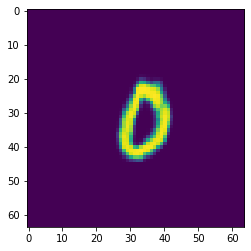

In [25]:
for i in range(sequence_number):
    x_0 = np.load(save_path + f'original/{i}/x1.npy')
    x_0 = torch.from_numpy(x_0[np.newaxis,np.newaxis,...])
    x_0 = x_0.to(device).float()
    
    x_1 = np.load(save_path + f'original/{i}/x2.npy')
    x_1 = torch.from_numpy(x_1[np.newaxis,np.newaxis,...])
    x_1 = x_1.to(device).float()

        
    x_2 = np.load(save_path + f'original/{i}/x3.npy')
    x_2 = torch.from_numpy(x_2[np.newaxis,np.newaxis,...])
    x_2 = x_2.to(device).float()

    x1_hat_FMD = ssf_FMD1(x_1,x_0)
    x2_hat_FMD = ssf_FMD2(x_2, x1_hat_FMD, x_0, x1_hat_FMD)
    
    os.makedirs(save_path + f'FMD_fine_tuning/{i}/', exist_ok=True)
    
    np.save(save_path + f'FMD_fine_tuning/{i}/x1.npy', x_0[0,0,...].cpu().data.numpy())
    np.save(save_path + f'FMD_fine_tuning/{i}/x2.npy', x1_hat_FMD[0,0,...].cpu().data.numpy())
    np.save(save_path + f'FMD_fine_tuning/{i}/x3.npy', x2_hat_FMD[0,0,...].cpu().data.numpy())
       if(i%100 == 0):
        print(i)

In [11]:
print(x_0[np.newaxis,np.newaxis,...].shape)

(1, 1, 64, 64)


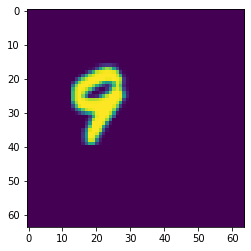

In [22]:
plt.imshow(x_0[0,0,...].cpu().data.numpy())

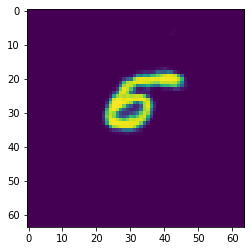

In [23]:
plt.imshow(x1_hat_FMD[0,0,...].cpu().data.numpy())

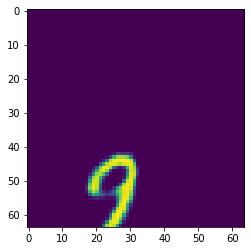

In [24]:
plt.imshow(x2_hat_FMD[0,0,...].cpu().data.numpy())